In [6]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import plyfile
import pandas
from importlib import reload
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from speed_regression import training_data as td
from speed_regression import regression
from speed_regression import regression_cascade
nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 10

In [2]:
option = td.TrainingDataOption()
extra_args = {'feature_smooth_sigma': 2.0,
              'target_smooth_sigma': 30.0}
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

In [60]:
model_path = '../../models/svr_cascade1105'
model = regression_cascade.load_model_from_file(model_path)

# num_sv_classifier = model.classifier.getSupportVectors().shape[0]
# num_sv_regressor = [reg.getSupportVectors().shape[0] for reg in model.regressors]
# print('Number of supporting vectors: {}, {}'.format(num_sv_classifier, num_sv_regressor))
# print('Total number of sv: ', num_sv_classifier + sum(num_sv_regressor))
print('Class map: ', model.class_map)

Class map:  {'transition': 4, 'bag': 2, 'body': 3, 'handheld': 0, 'leg': 1}


In [29]:
# load testing data
train_feature, train_label, train_responses, _ = regression_cascade.load_datalist('../../data2/list_train_1031.txt',
                                                                                 option, model.class_map)

train_responses = train_responses[:, [0, 2]]

Loading dataset ../../data2/hang_handheld_speed1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_stop1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_leg_front1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_front2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_stop1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_body_backward1/processed/data.csv, type: body
Loading dataset ../../data2/hang_body_backward3/processed/data.csv, type

In [58]:
test_feature, test_label, test_responses, _ = regression_cascade.load_datalist('../../data2/list_test_allsub.txt',
                                                                              option, model.class_map)
test_responses = test_responses[:, [0, 2]]
feature_classes = [test_feature[test_label==cls].astype(np.float32)
                   for cls in model.class_map.values()]
response_classes = [test_responses[test_label==cls].astype(np.float32)
                    for cls in model.class_map.values()]

Loading dataset ../../data2/hang_handheld_normal2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_speed2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_body_backward2/processed/data.csv, type: body
Loading dataset ../../data2/hang_leg_front3/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin2/processed/data.csv, type: bag
Loading dataset ../../data2/huayi_handheld2/processed/data.csv, type: handheld
Loading dataset ../../data2/huayi_leg2/processed/data.csv, type: leg
Loading dataset ../../data2/yajie_handheld2/processed/data.csv, type:

In [9]:
# Test with the baseline model
channel_list = [0, 2]
predicted_all = [[], []]
gt_all = [[], []]
time_for_testing = 0
for i in range(2):
    regressor = cv2.ml.SVM_load('../../models/SVR_allinone_1023_w200_s10_{}.yml'.format(channel_list[i]))
    print('Model loaded')
    t = time.time()
    for cls in model.class_map.values():
        predicted = regressor.predict(feature_classes[cls])[1].ravel()
        # r2 = r2_score(predicted, response_classes[cls][:, chn])
        mse = mean_squared_error(predicted, response_classes[cls][:, i])
        print('Baseline, class %d, channel %d, score: %f(MSE)' % (cls, i, mse))
        predicted_all[i].append(predicted)
        gt_all[i].append(response_classes[cls][:, i])
    time_for_testing += time.time() - t
for i in range(2):
    predicted_all[i] = np.concatenate(predicted_all[i], axis=0)
    gt_all[i] = np.concatenate(gt_all[i], axis=0)
    mse = mean_squared_error(predicted_all[i], gt_all[i])
    print('Overall regression error for channel %d: %f(MSE)' % (i, mse))
print('Time usage: ', time_for_testing)

Model loaded
Baseline, class 1, channel 0, score: 0.020586(MSE)
Baseline, class 0, channel 0, score: 0.020788(MSE)
Baseline, class 3, channel 0, score: 0.041892(MSE)
Baseline, class 2, channel 0, score: 0.006795(MSE)
Model loaded
Baseline, class 1, channel 1, score: 0.028263(MSE)
Baseline, class 0, channel 1, score: 0.013092(MSE)
Baseline, class 3, channel 1, score: 0.045071(MSE)
Baseline, class 2, channel 1, score: 0.013720(MSE)
Overall regression error for channel 0: 0.022995(MSE)
Overall regression error for channel 1: 0.024688(MSE)
Time usage:  255.67447972297668


In [12]:
## Training error
t = time.time()
print('Training error')
label_predicted_on_train, response_predicted_on_train = model.test(train_feature, train_label, train_responses)
print('Time usage: ', time.time() - t)

Training error
Classification accuracy:  0.907179814093
Error for class 1, channel 0: 0.113370(MSE)
Error for class 1, channel 1: 0.144594(MSE)
Error for class 2, channel 0: 0.030945(MSE)
Error for class 2, channel 1: 0.020930(MSE)
Error for class 3, channel 0: 0.013872(MSE)
Error for class 3, channel 1: 0.028358(MSE)
Error for class 0, channel 0: 0.048855(MSE)
Error for class 0, channel 1: 0.038109(MSE)
Overall regression error for channel 0: 0.888635(R2), 0.043260(MSE)
Overall regression error for channel 1: 0.885887(R2), 0.050410(MSE)
Time usage:  88.85662341117859


In [59]:
# Testing error
t = time.time()
print('Testing error')
label_predicted, response_predicted = model.test(test_feature, test_label, test_responses)
print('Time usage: ', time.time() - t)

Testing error
Classification accuracy:  0.935985844024
Error for class 2, channel 0: 0.012698(MSE)
Error for class 2, channel 1: 0.013418(MSE)
Error for class 3, channel 0: 0.006101(MSE)
Error for class 3, channel 1: 0.009952(MSE)
Error for class 0, channel 0: 0.019848(MSE)
Error for class 0, channel 1: 0.018182(MSE)
Error for class 1, channel 0: 0.016263(MSE)
Error for class 1, channel 1: 0.007215(MSE)
Overall regression error for channel 0: 0.949392(R2), 0.016617(MSE)
Overall regression error for channel 1: 0.968451(R2), 0.017135(MSE)
Time usage:  272.4959638118744


In [18]:
# Compute the confusion matrix. 
# confusion_matrix[i, j] means the number of samples with the class i predicted as the class j.
num_classes = model.num_classes
confusion_matrix = np.zeros([num_classes, num_classes], dtype=np.int)
for i in range(label_predicted.shape[0]):
    confusion_matrix[test_label[i], int(label_predicted[i])] += 1
print('Class map: ', model.class_map)
print(confusion_matrix)
# The classification accuracy is the sum of the diagonal elements divided by the sum of the whole matrix. Make sure
# this number matches the testing accuracy.
accuracy = np.sum(np.diagonal(confusion_matrix).astype(np.float)) / np.sum(confusion_matrix).astype(np.float)
print('Accuracy: ', accuracy)

# # Draw the confusion matrix
# confusion_matrix = confusion_matrix.astype(float) / label_predicted.shape[0]
# print('Confusion_normalized\n', confusion_matrix)

# plt.imshow(confusion_matrix, interpolation='nearest')

Class map:  {'leg': 1, 'bag': 2, 'body': 3, 'handheld': 0, 'transition': 4}
[[14451     0    35   867    46]
 [   24 11584    69   899  1976]
 [    2     1  7965   697   140]
 [   38     0    11  5944     6]
 [    0     0     0     0     0]]
Accuracy:  0.892503630879


In [30]:
# Analyze the model
dummy_feature = test_feature[0, :]
sv_classification = model.classifier.getSupportVectors()
dim = sv_classification.shape[1]

dtype = {'names': ['f{}'.format(i) for i in range(dim)],
        'formats': dim * [sv_classification.dtype]}

num_shared_sv = 0
for cls in range(model.num_classes):
    sum_cls = 0
    for chn in range(model.num_channels):
        sv_regressor = model.regressors[cls * model.num_channels + chn].getSupportVectors()
        inter = np.intersect1d(sv_classification.view(dtype), sv_regressor.view(dtype))
        print('Number of shared SV for class {}, channel {}: {}'.format(cls, chn, inter.shape[0]))
        sum_cls += inter.shape[0]
        num_shared_sv += inter.shape[0]
    print('Shared SV for class {}: {}'.format(cls, sum_cls))
print('Unshared SV: ', sv_classification.shape[0] - num_shared_sv)
print('Total number of shared sv: {:d}, ratio: {:f}'.format(num_shared_sv, num_shared_sv
                                                            / sv_classification.shape[0]))

Number of shared SV for class 0, channel 0: 951
Number of shared SV for class 0, channel 1: 1323
Shared SV for class 0: 2274
Number of shared SV for class 1, channel 0: 2025
Number of shared SV for class 1, channel 1: 2036
Shared SV for class 1: 4061
Number of shared SV for class 2, channel 0: 1226
Number of shared SV for class 2, channel 1: 1151
Shared SV for class 2: 2377
Number of shared SV for class 3, channel 0: 1134
Number of shared SV for class 3, channel 1: 1222
Shared SV for class 3: 2356
Unshared SV:  301
Total number of shared sv: 11068, ratio: 0.973524


In [43]:
model_old = regression_cascade.load_model_from_file('../../models/svr_cascade1031')
# model_new = regression_cascade.load_model_from_file('../../models/svr_cascade1031')
model_new = model

In [61]:
# Load a single dataset and plot the speed
data_single = pandas.read_csv('../../data_mixture/bag_handheld_leg_cse1/processed/data.csv')
gyro = data_single[['gyro_x', 'gyro_y', 'gyro_z']].values
# plt.figure('gyro')
# plt.plot(gyro[:, 2])

t = data_single['time']
option2 = td.TrainingDataOption(sample_step=50)
# sample_points = np.arange(option.window_size_, t.shape[0] - 1, 50)
feature_single, response_single = td.get_training_data(data_all=data_single, imu_columns=imu_columns,
                                                       option=option2, extra_args=extra_args)
response_single = response_single[:, [0, 2]]

<IPython.core.display.Javascript object>


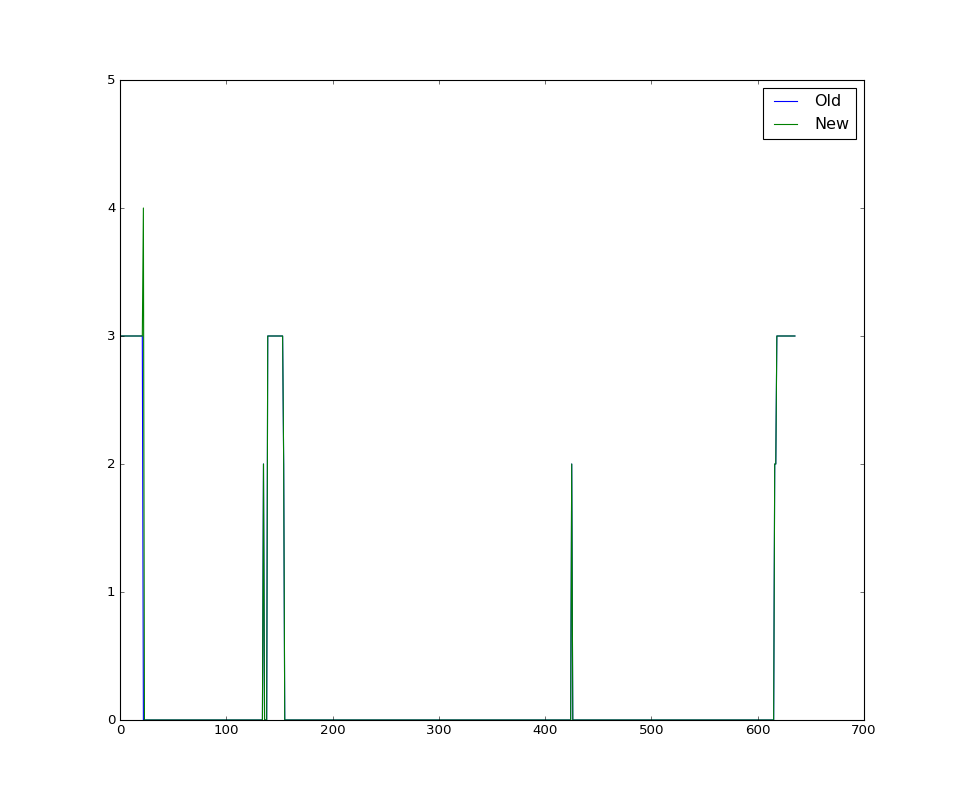

<IPython.core.display.Javascript object>


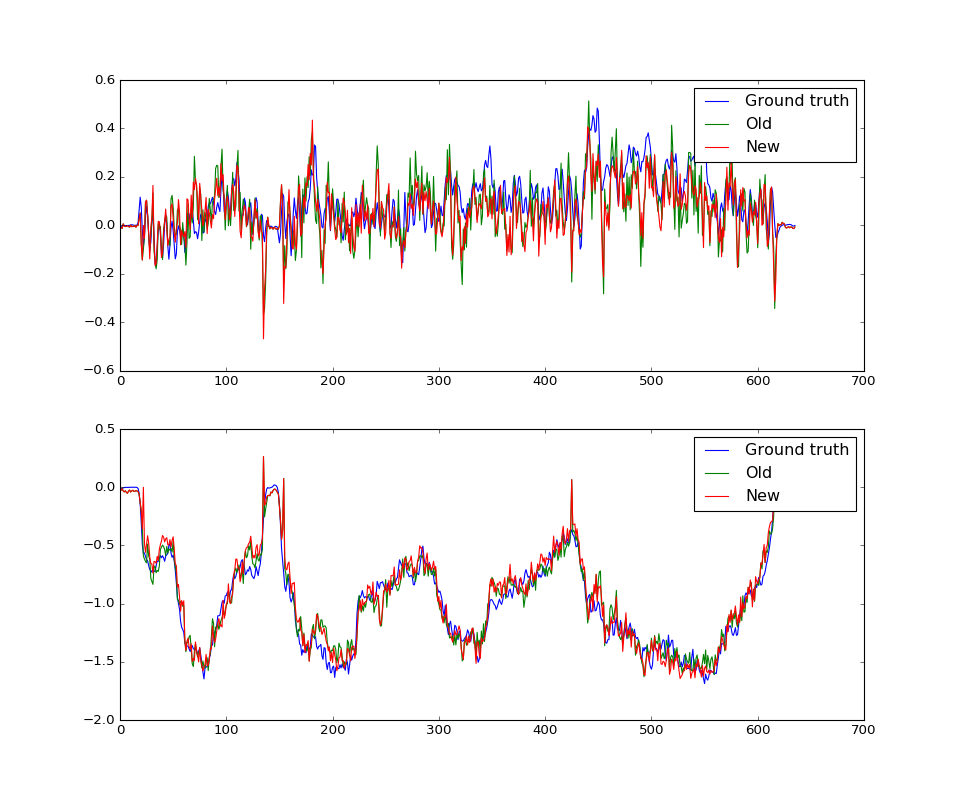

In [44]:
label_old, response_old = model_old.test(feature_single, None, None)
label_new, response_new = model_new.test(feature_single, None, None)

plt.figure('Label')
plt.ylim(ymax=5)
plt.plot(label_old)
plt.plot(label_new)
plt.legend(['Old', 'New'])

plt.figure('Regression')
for i in range(2):
    plt.subplot(211 + i)
    plt.plot(response_single[:, i])
    plt.plot(response_old[:, i])
    plt.plot(response_new[:, i])
    plt.legend(['Ground truth', 'Old', 'New'])

Accuracy:  0.0366013071895


<IPython.core.display.Javascript object>


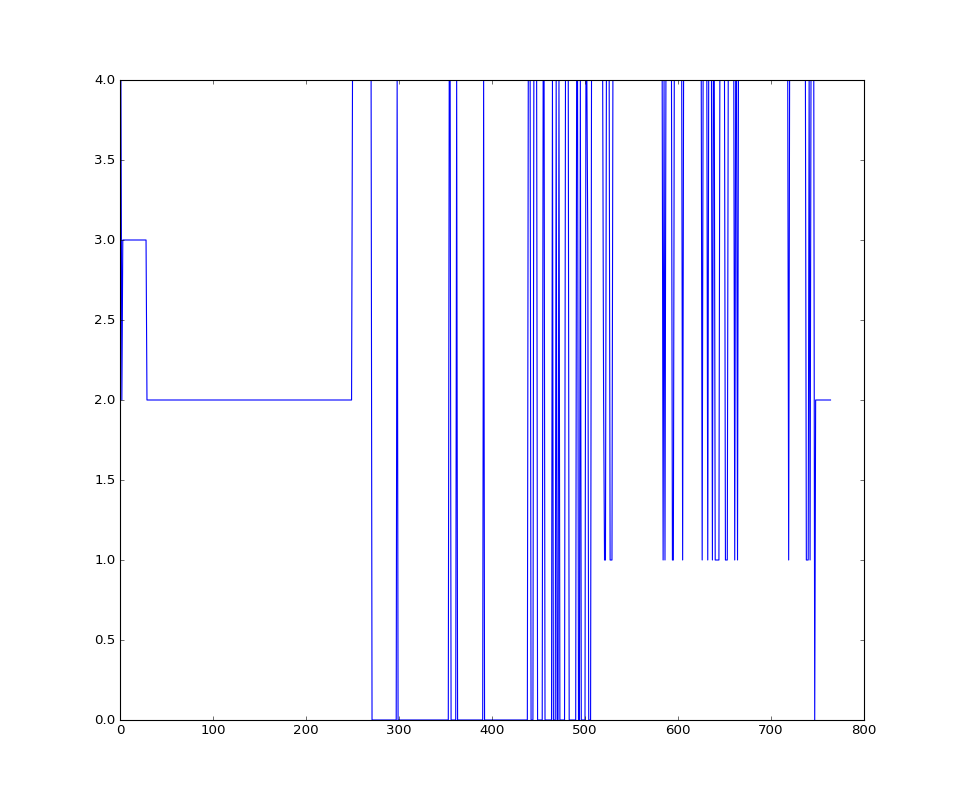

In [62]:
# Experiment with trained classifier
svm = cv2.ml.SVM_load('../../models/svr_cascade1105/classifier.yaml')
predicted_label = svm.predict(feature_single.astype(np.float32))[1].ravel()

true_label = np.ones(predicted_label.shape[0], dtype=np.int)
print('Accuracy: ', accuracy_score(y_pred=predicted_label.astype(np.int), y_true=true_label))

plt.figure('Classification')
plt.plot(predicted_label)